### Михаил Ховричев

Будем составлять программу и проводить анализ по ходу действия. В этом блокноте анализируется текст по выбору. Анализ главы "Алисы в стране чудес"  -- в аналогичном блокноте.

Python 3.4
Для токенизации используется NLTK. Сегментацию он тоже осуществляет, но качество сегментации оставило желать лучшего.
Морфологический анализатор: pymorphy2.
Для построения графиков: matplotlib.

Часть комментариев для удобства будет в самом коде.

In [2]:
%matplotlib inline
import pymorphy2
from nltk import word_tokenize, sent_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from pprint import pprint

morph = pymorphy2.MorphAnalyzer()

Функция для быстрого построения столбчатых диаграмм с нормализацией (высота столбца -- проценты)

In [3]:
def barchart(dic, normalizer, title):
    plt.bar(range(len(dic)), sorted([100*x/normalizer for x in list(dic.values())], reverse=True), width=0.8, color='g')
    plt.xticks(range(len(dic)), sorted(dic, key=dic.get, reverse=True), rotation=45)
    plt.title(title)
    plt.show()

In [1]:
text = open('article.txt', 'r')
string = text.read()

In [4]:
tokens = word_tokenize(string)

Список токенов выглядит примерно так:

In [5]:
pprint(tokens[:10])

['Сначала', '—', 'две', 'оговорки', '.', 'Первая', '.', 'Те', ',', 'к']


In [6]:
# Уберём знаки пунктуации и неразобранные токены, остальное выглядит примерно так
words = [morph.parse(token)[0] for token in tokens if not ('PNCT' in morph.parse(token)[0].tag or 'UNKN' in morph.parse(token)[0].tag)]
words[:10]

[Parse(word='сначала', tag=OpencorporaTag('ADVB'), normal_form='сначала', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'сначала', 3, 0),)),
 Parse(word='две', tag=OpencorporaTag('NUMR femn,nomn'), normal_form='два', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'две', 1248, 7),)),
 Parse(word='оговорки', tag=OpencorporaTag('NOUN,inan,femn sing,gent'), normal_form='оговорка', score=0.3333333333333333, methods_stack=((<DictionaryAnalyzer>, 'оговорки', 8, 1),)),
 Parse(word='первая', tag=OpencorporaTag('ADJF,Anum femn,sing,nomn'), normal_form='один', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'первая', 2198, 33),)),
 Parse(word='те', tag=OpencorporaTag('ADJF,Apro,Subx,Anph plur,nomn'), normal_form='тот', score=0.75, methods_stack=((<DictionaryAnalyzer>, 'те', 2900, 19),)),
 Parse(word='к', tag=OpencorporaTag('PREP'), normal_form='к', score=0.998113, methods_stack=((<DictionaryAnalyzer>, 'к', 375, 0),)),
 Parse(word='кому', tag=OpencorporaTag('NOUN,inan,femn sing,accs'), norma

#### Общестатистические характеристики

Посчитаем количество словоупотреблений и словоформ:

In [7]:
wordforms = [item.word for item in words]
unique_wordforms = {word: len(word) for word in wordforms} # На всякий случай будем хранить ещё и длину
print('Количество словоупотреблений:', len(wordforms))
print('Количество словоформ:', len(unique_wordforms))

Количество словоупотреблений: 677
Количество словоформ: 402


#### Морфологические характеристики

Узнаем процент различных частей речи:

[('NOUN', 165), ('ADJF', 125), ('CONJ', 83), ('PREP', 72), ('NPRO', 57)]


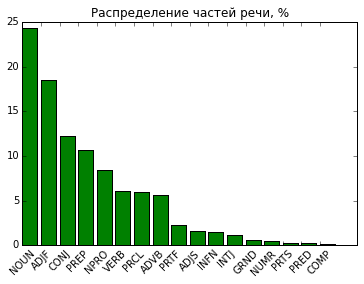

In [8]:
poscounter = Counter([word.tag.POS for word in words])
print(poscounter.most_common(5)) # 5 самых популярных частей речи
barchart(poscounter, len(wordforms), "Распределение частей речи, %")

**Важно!**
В pymorphy2 несколько другая классификация частей речи. Например, инфинитив -- отдельная от глагола часть речи. Краткие и полные прилагательные также относятся к различным частям речи. 

Полный список см. <a href="https://pymorphy2.readthedocs.io/en/latest/user/grammemes.html">здесь</a> и  <a href="http://opencorpora.org/dict.php?act=gram">здесь</a>.

Похожим образом узнаем абсолютную и относительную частоту падежей у существительных:

[('gent', 60), ('nomn', 49), ('accs', 22)]


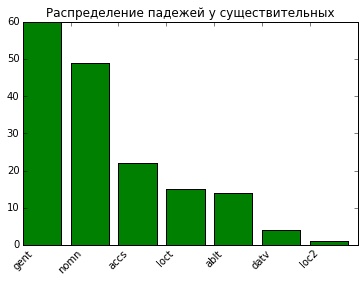

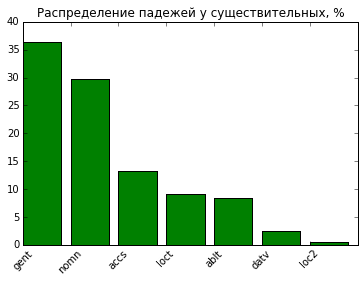

In [9]:
nouncase = Counter([word.tag.case for word in words if word.tag.POS=='NOUN'])
print(nouncase.most_common(3))
barchart(nouncase, 100, "Распределение падежей у существительных")
barchart(nouncase, poscounter['NOUN'], "Распределение падежей у существительных, %")

Видим, что наиболее частотны генетив, номинатив и аккузатив.

То же, с прилагательными (полными):

[('nomn', 47), ('gent', 44), ('accs', 12)]


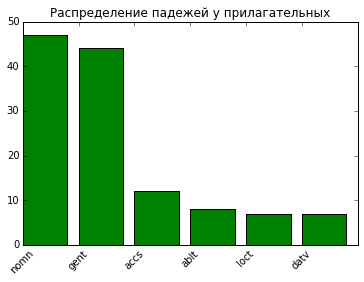

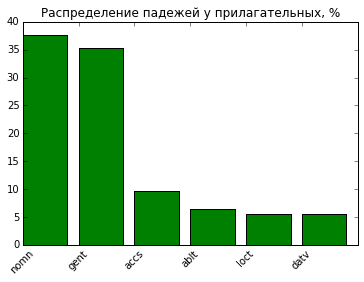

In [10]:
adjcase = Counter([word.tag.case for word in words if word.tag.POS=='ADJF'])
print(adjcase.most_common(3))
barchart(adjcase, 100, "Распределение падежей у прилагательных")
barchart(adjcase, poscounter['ADJF'], "Распределение падежей у прилагательных, %")

Снова лидируют номинатив, генетив и аккузатив. А если среди всех частей речи?

[('nomn', 130), ('gent', 119), ('accs', 52)]


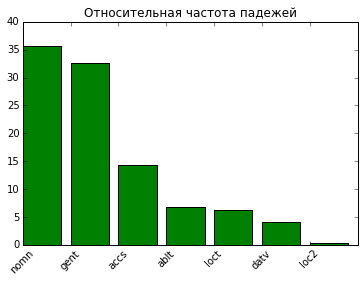

In [11]:
casecounter = Counter([word.tag.case for word in words if word.tag.case is not None])
print(casecounter.most_common(3))
barchart(casecounter, len([word.tag.case for word in words if word.tag.case is not None]), "Относительная частота падежей")

Да, эти три падежа -- самые популярные.

Выясним наиболее частотные морфологические формы глаголов (по общей форме, и по времени/лицу/числу в отдельности):

In [12]:
verbs = [word for word in words if word.tag.POS=='VERB']
verbstags = Counter([verb.tag.cyr_repr for verb in verbs]) #Демонстрация возможностей использования русскоязычных граммем
verbstenses = Counter([verb.tag.tense for verb in verbs])
verbsperson = Counter([verb.tag.person for verb in verbs])
verbsnumber = Counter([verb.tag.number for verb in verbs])

In [13]:
pprint(verbstags.most_common(3))

[('ГЛ,несов,неперех ед,3л,наст,изъяв', 11),
 ('ГЛ,несов,перех ед,3л,наст,изъяв', 7),
 ('ГЛ,сов,перех мр,ед,прош,изъяв', 6)]


Теперь для каждой характеристики отдельно:

In [14]:
pprint(verbstenses.most_common())

[('pres', 24), ('past', 14), ('futr', 3)]


In [15]:
pprint(verbsperson.most_common())

[('3per', 24), (None, 14), ('1per', 3)]


Заметим, что в большинстве глаголов лицо не определилось.

In [16]:
pprint(verbsnumber.most_common())

[('sing', 33), ('plur', 8)]


Глаголов в ед.ч больше.

#### Лексические характеристики

Подсчитаем число уникальных лемм, для каждой будем хранить часть речи. Здесь объединим инфинитивы и глаголы.

In [17]:
lemmas = [[word.normal_form, word.tag.POS] for word in words]

for tuple in lemmas:
    if tuple[1]=='INFN':
        tuple[1]='VERB'
    

lemmas = [(elem[0], elem[1]) for elem in lemmas]
lemmas = list(set(lemmas))
print("Число уникальных лемм:", len(lemmas))
print("Число уникальных лемм существительных:", len([lemm for lemm in lemmas if lemm[1]=='NOUN']))
print("Число уникальных лемм глаголов:", len([lemm for lemm in lemmas if lemm[1]=='VERB']))
print("Число уникальных лемм прилагательных:", len([lemm for lemm in lemmas if lemm[1]=='ADJF']))
print("Число уникальных лемм наречий:", len([lemm for lemm in lemmas if lemm[1]=='ADVB']))
print("Число незнакомых слов:", len([lemm for lemm in lemmas if lemm[1]==None]))

Число уникальных лемм: 317
Число уникальных лемм существительных: 97
Число уникальных лемм глаголов: 39
Число уникальных лемм прилагательных: 58
Число уникальных лемм наречий: 29
Число незнакомых слов: 0


"Незнакомыми словами" назовём слова с неопределённой частью речи. Таких нет.

Теперь узнаем самые частотные слова и их относительную частоту в процентах (с точностью 5 знаков после запятой)

In [18]:
wordscounter = Counter([word for word in wordforms])
pprint([(w,round(100*f/len(wordforms), 5)) for (w,f) in wordscounter.most_common(10)])

[('и', 4.13589),
 ('в', 3.54505),
 ('не', 1.92024),
 ('что', 1.77253),
 ('от', 1.4771),
 ('я', 1.18168),
 ('есть', 1.18168),
 ('его', 1.18168),
 ('все', 1.03397),
 ('на', 1.03397)]


То же для существительных:

In [19]:
nouncounter = Counter([word.word for word in words if word.tag.POS=='NOUN'])
pprint([(w,round(100*f/poscounter['NOUN'], 5)) for (w,f) in nouncounter.most_common(5)])

[('безумие', 3.0303),
 ('вопрос', 2.42424),
 ('люди', 1.81818),
 ('уровень', 1.81818),
 ('кому', 1.81818)]


Для прилагательных:

In [20]:
adjcounter = Counter([word.word for word in words if word.tag.POS=='ADJF'])
pprint([(w,round(100*f/poscounter['ADJF'], 5)) for (w,f) in adjcounter.most_common(5)])

[('все', 5.6),
 ('этот', 3.2),
 ('безумных', 3.2),
 ('своих', 2.4),
 ('нормальных', 2.4)]


То же у глаголов:

In [21]:
verbcounter = Counter([word.word for word in words if (word.tag.POS=='VERB' or word.tag.POS=='INFN')])
pprint([(w,round(100*f/(poscounter['VERB']+poscounter['INFN']), 5)) for (w,f) in verbcounter.most_common(5)])

[('быть', 5.88235),
 ('может', 3.92157),
 ('был', 3.92157),
 ('применяется', 3.92157),
 ('остаётся', 3.92157)]


И наречий:

In [22]:
adverbcounter = Counter([word.word for word in words if word.tag.POS=='ADVB'])
pprint([(w,round(100*f/poscounter['ADVB'], 5)) for (w,f) in adverbcounter.most_common(5)])

[('тогда', 7.89474),
 ('потому', 7.89474),
 ('почему', 5.26316),
 ('ясно', 5.26316),
 ('сначала', 5.26316)]


Коэффициент лексического разнообразия (lexical diversity): 

In [23]:
LD = len(lemmas)/len(wordforms)
print(round(LD,5))

0.46824


Таким образом, было подсчитано порядка 16 характеристик текста.